<a href="https://colab.research.google.com/github/coolcat218/Voronoi-Art/blob/main/Voronoi_Art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Voronoi Art x Cezanne
 A Voronoi diagram is a partition of a plane into regions close to each of a given set of objects.
 It  starts with points (called seeds) on a plane. For each seed there is a corresponding region, called a Voronoi cell, consisting of all points of the plane closer to that seed than to any other.

 It can be observed naturally in plant cells, tree canopies, butterfly wings, etc.

 Separately, Paul Cezanne was a French painter who breaks down images into their representational geometric primitives (and is also one of my favorite artists!). Each patch of color seems to represent a plane and multiple planes overlap to mimic space and depth.

 In this exercise, I'll attempt to break down an image with a Voronoi overlay and apply Cezanne's stylistic breakdown onto a real image.

In [1]:
!pip install torch torchvision pillow scipy matplotlib opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

This uses two images, one for content and the other for style. Here I've uploaded an image of Washington Square Park and a Cezanne painting for the style reference image.

VGG19 is a pre-trained convolutional neural network used here to extract features from images at different layers. the lower layers capture basic features like corners and the deeper layers capture the more complex patterns.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import cv2

# ---- Utility functions ----

def image_loader(image_path, imsize=512):
    loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

# ---- Neural Style Transfer Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Normalization
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .clone() non-inplace
        self.mean = torch.tensor(mean).clone().view(-1, 1, 1)
        self.std = torch.tensor(std).clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# ---- Style Transfer Helper (from PyTorch Tutorial) ----
# Content and style losses
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # .detach() to avoid backprop through the target
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    # normalize the gram matrix
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # .detach() to avoid backprop through the target
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

In [3]:
# ---- Build Style Transfer Model ----
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    return model, style_losses, content_losses

# ---- Run Style Transfer ----
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=200,
                       style_weight=1e6, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img
    )
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= num_steps:
        def closure():
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            return style_score + content_score
        optimizer.step(closure)
    return input_img


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from scipy.spatial import Voronoi
from collections import Counter

# Upload files
content_img = image_loader("image.jpg")
style_img = image_loader("Cezanne_Style2.jpg")

# Run transfer
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=1e7, content_weight=1e-1)

# ---- Convert to numpy ----
unloader = transforms.ToPILImage()
output_img = unloader(output.cpu().squeeze(0))

/tmp/ipython-input-1137042388.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipython-input-1137042388.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [23]:
# place voronoi seed points where the image shows high contrast (will convert to grayscale and place seeds where there are actual differences in the original image)

def voronoi_overlay(
    pil_img, num_points=100, alpha=0.8,
    use_dominant=False, save_path="voronoi_contrast_color.png"
):
    img = np.array(pil_img)
    h, w, _ = img.shape

    # 1. Grayscale + contrast detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    contrast_map = cv2.Laplacian(gray, cv2.CV_64F)
    contrast_map = np.abs(contrast_map)

    # 2. Sample seeds weighted by contrast
    ys, xs = np.indices(gray.shape)
    coords = np.stack((xs.flatten(), ys.flatten()), axis=-1)
    weights = contrast_map.flatten() + 1e-6
    weights /= weights.sum()
    chosen = np.random.choice(len(coords), size=num_points, replace=False, p=weights)
    points = coords[chosen]

    # 3. Voronoi diagram
    vor = Voronoi(points)

    # 4. Image bounding box
    bbox = box(0, 0, w, h)

    # 5. Plotting
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    def increase_saturation(rgb, factor=1.5):
        # Convert RGB to HSV
        hsv = cv2.cvtColor(np.uint8([[rgb]]), cv2.COLOR_RGB2HSV)[0][0]
        # Increase saturation
        hsv[1] = min(255, int(hsv[1] * factor))
        # Convert back to RGB
        return cv2.cvtColor(np.uint8([[hsv]]), cv2.COLOR_HSV2RGB)[0][0]


    for region in vor.regions:
        if not region or -1 in region:
            continue
        polygon = [vor.vertices[i] for i in region]
        poly = Polygon(polygon)

        # Clip polygon to image bounds
        clipped = poly.intersection(bbox)
        if clipped.is_empty:
            continue

        polys = [clipped] if clipped.geom_type == "Polygon" else list(clipped)

        for subpoly in polys:
            x, y = subpoly.exterior.xy
            mask = np.zeros((h, w), dtype=np.uint8)
            pts = np.array(list(zip(x, y)), dtype=np.int32)
            cv2.fillPoly(mask, [pts], 1)

            # Pick color (average or dominant)
            pixels = img[mask == 1]

            if pixels.size > 0:
                if use_dominant:
                    # Dominant color = most frequent pixel in the region
                    pixels_tuples = [tuple(p) for p in pixels]
                    dominant_color = Counter(pixels_tuples).most_common(1)[0][0]
                    facecolor = np.array(dominant_color)
                else:
                    # Average color
                    mean_color = pixels.mean(axis=0)
                    facecolor = mean_color
            else:
                facecolor = np.random.randint(0, 256, 3)

            # Increase saturation
            saturated_color = increase_saturation(facecolor)
            facecolor_normalized = saturated_color / 255.0

            ax.fill(x, y, alpha=alpha, edgecolor="white", facecolor=facecolor_normalized)

    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)
    ax.axis("off")
    plt.tight_layout()

    # Save result
    fig.savefig(save_path, dpi=150, bbox_inches="tight", pad_inches=0)
    plt.show()
    print(f"Saved Voronoi overlay as {save_path} (dominant={use_dominant})")

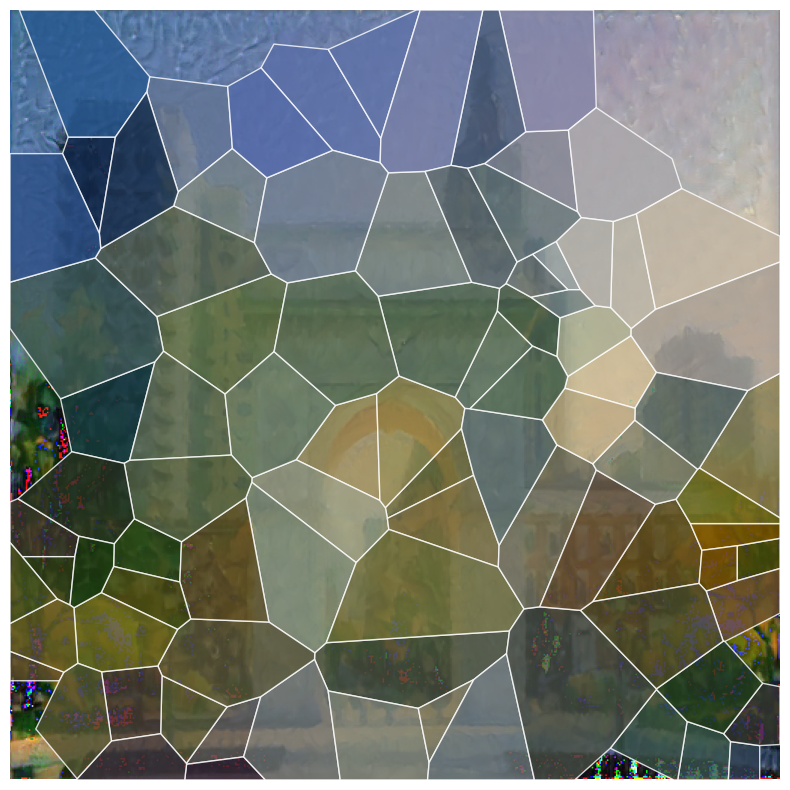

Saved Voronoi overlay as voronoi_contrast_color.png (dominant=False)


In [20]:
voronoi_overlay(output_img, num_points=100, alpha=0.8)

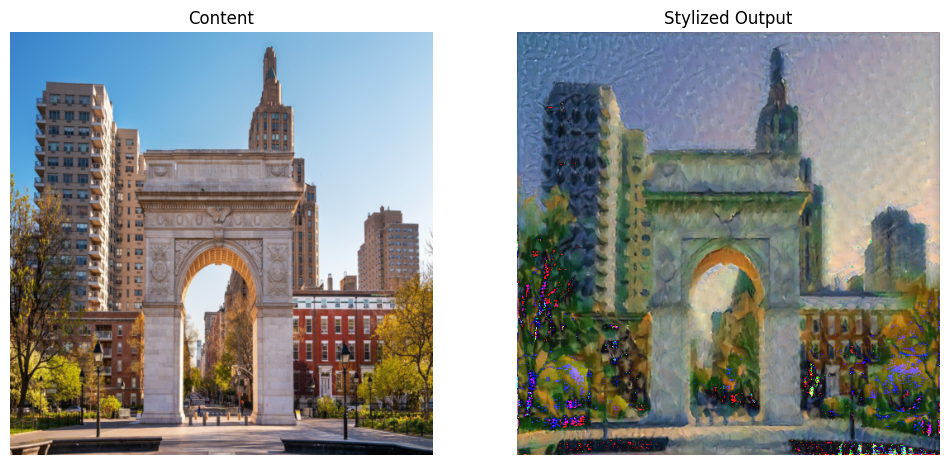

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(unloader(content_img.squeeze(0)))
ax[0].set_title("Content")
ax[0].axis("off")
ax[1].imshow(output_img)
ax[1].set_title("Stylized Output")
ax[1].axis("off")
plt.show()

In [ ]:
plt.show()
output_img.save("stylized_output.jpg")
print("Saved as stylized_output.jpg")

Saved as stylized_output.jpg


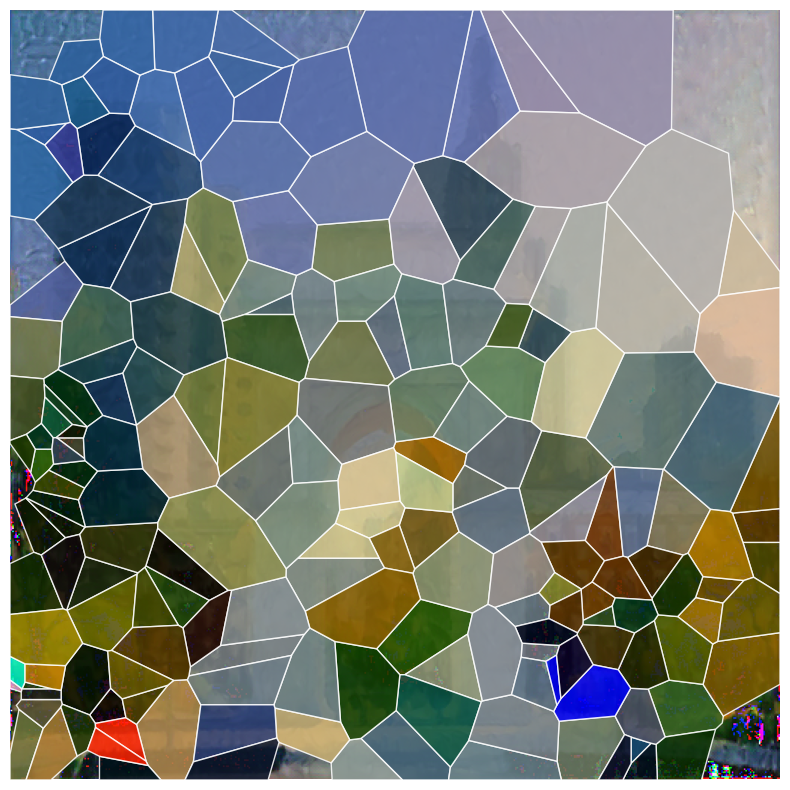

Saved Voronoi overlay as voronoi_contrast_color.png (dominant=True)


In [24]:
# In defining the voronoi overlay function, we set the color of the planes to be either the average of the pixels included or the dominant color, which is defined as the most frequent pixel. Using the dominant color would result in a higher saturation, or a stronger color:

voronoi_overlay(output_img, num_points=200, alpha=0.85, use_dominant=True)